# Wrangling Data From Bay Area Bike Share Published Data - Status

### Import Packages

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import datetime

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("poster")

In [2]:
from wranglingutils import time_marker as tm
from wranglingutils import csv_chunk_importer

In [3]:
from math import ceil

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25
TICK_FONT_SIZE = LABEL_FONT_SIZE*0.8
FIG_SIZE = (15,6)

## Import Data
<p>We are only including data for San Francisco Stations in this analysis, prune all others</p>
<p>Customer csv loading is needed here, date formatting is inconsistnet in raw data set and speeds up with specialized handling</p>

In [5]:
sf_stations_df = csv_chunk_importer(file_path_slug='../../clean_data/bayareabikeshare/sf_station_*.csv', 
                                 chunk_size=10000, 
                                 drop_dups=True)
sf_station_ids = sf_stations_df.station_id.unique()

[23:44:13.936743] Started Loading Data...
[23:44:13.949302] Finished file! (1 of 1)
[23:44:13.949429] concatenating chunks...
[23:44:14.034432] Data Loaded Successfully!


In [6]:
tm('Loading Status Data...')

# glob all files
from glob import glob
file_path_slug = '../../source_data/bayareabikeshare/*_status_data.csv'
file_list = glob(file_path_slug)

status_df = pd.DataFrame()
chunks = []

# load data from each file
for fn, file in enumerate(file_list):
    file_name = file.split('/')[-1]
    tm('Loading file {}'.format(file_name))

    chunksize = 10000
    num_chunks = ceil(sum(1 for row in open(file, 'r'))/chunksize)

    # import file in chunks
    for chunk in pd.read_csv(file, chunksize=chunksize, iterator=True):
                
        # correct date time formatting
        if file_name == '201408_status_data.csv' or file_name == '201508_status_data.csv':
            # 2014-03-01 00:00:02
            chunk['time'] = pd.to_datetime(chunk['time'],   
                                           format="%Y-%m-%d %H:%M:%S").values.astype('<M8[m]')
            
        if file_name == '201608_status_data.csv':
            # 9/1/2015 00:00:02
            chunk['time'] = pd.to_datetime(chunk['time'],   
                                           format="%m/%d/%Y %H:%M:%S").values.astype('<M8[m]')
        
        if file_name == '201402_status_data.csv':
            # 2013/08/29 12:06:01
            chunk['time'] = pd.to_datetime(chunk['time'],   
                                           format="%Y/%m/%d %H:%M:%S").values.astype('<M8[m]')
            
        chunks.append(chunk)

    tm('Finished file! ({:d} of {:d})\n'.format(fn+1, len(file_list)))

tm('Merging chunks to dataframes')
status_df = pd.concat(chunks)
tm('Data Loaded Successfully!')

[23:44:14.171595] Loading Status Data...
[23:44:14.174755] Loading file 201408_status_data.csv
[23:45:11.237395] Finished file! (1 of 4)
[23:45:11.237576] Loading file 201508_status_data.csv
[23:47:04.816104] Finished file! (2 of 4)
[23:47:04.816291] Loading file 201608_status_data.csv
[23:52:41.712979] Finished file! (3 of 4)
[23:52:41.713315] Loading file 201402_status_data.csv
[23:53:31.479098] Finished file! (4 of 4)
[23:53:31.479452] Merging chunks to dataframes
[23:53:57.660289] Data Loaded Successfully!


In [7]:
tm('Cleaning up duplicates')
status_df.drop_duplicates(inplace=True)
tm('Resetting Index')
status_df.reset_index(drop=True, inplace=True)
tm('Complete!\n')
status_df.head(3)

[23:53:57.719321] Cleaning up duplicates
[23:56:57.182816] Resetting Index
[23:56:57.330568] Complete!


,station_id,bikes_available,docks_available,time
0,2,12,15,2014-03-01 00:00:00
1,2,12,15,2014-03-01 00:01:00
2,2,12,15,2014-03-01 00:02:00


In [8]:
status_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107233299 entries, 0 to 107233298
Data columns (total 4 columns):
station_id         int64
bikes_available    int64
docks_available    int64
time               datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.2 GB


# Cleaning Functions

In [9]:
def show_station(df, id, time_min, time_max, x_label = '', y_label = '', title_suffix='', color='b', col='bikes_available'):
    '''Plot Usage of station between two time stamps
        usage is default the number of 'bikes_available' at any given time period
    '''
    t = pd.DataFrame()
    t = df[df.station_id == id]
    t.set_index('time', inplace=True)
    ax = t[col].plot(color=color, figsize=(24,3))
    ax.set_xlim(time_min, time_max)
    if title_suffix != '':
        title = 'Station %s - %s' % (id, title_suffix)
    elif y_label != '':
        title = 'Station %s - %s' % (id, y_label)
    else:
        title = 'Station %s' % id
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel(x_label, size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
    plt.show()
    plt.close()
    
    # empty out t dataframe, HOpefully more memory concious
    t = pd.DataFrame()

In [10]:
def date_fixes(df=None, old_station=0, new_station=0, change_date=None):
    '''Update status records from old station id to new station id on dates following the change date value '''
    tm('Updating {} to {} for dates after {}'.format(old_station, new_station, change_date))

    tm('Started indexing...')
    index_to_update = df[(df.station_id == old_station) & (df.time >= change_date)].index
    tm('Complete!')

    station_check = [old_station, new_station]

    t_min = pd.Timestamp('2013-07-01')
    t_max = pd.Timestamp('2016-10-01')

    tm('Started Update...')
    df.loc[index_to_update, 'station_id'] = new_station
    tm('Complete!')

    for station in station_check:
        show_station(df, station, t_min, t_max)
    
    return df

# Drop station 87, there is no station 87

In [11]:
# drop station 87 - there is no station 87
tm('Removing Station 87 status, there is no station 87')
tm('\t\tremoving {:d} items'.format(status_df[status_df.station_id == 87].shape[0]))
status_df = status_df[status_df.station_id != 87].copy()
tm('Complete')

[23:56:57.821061] Removing Station 87 status, there is no station 87
[23:57:00.674030] removing 161 items
[23:57:43.643613] Complete


# Correct Relocated Stations
<p>From the notes included with the dataset, there was a delay in the renaming of stations relocated when services in Redwood City was discontinued.</p>
<p>Here we will first look at the incorrect data, and then correct the status's with relocated stations to proper dates.</p>

## 'Old' Stations prior to cleaning

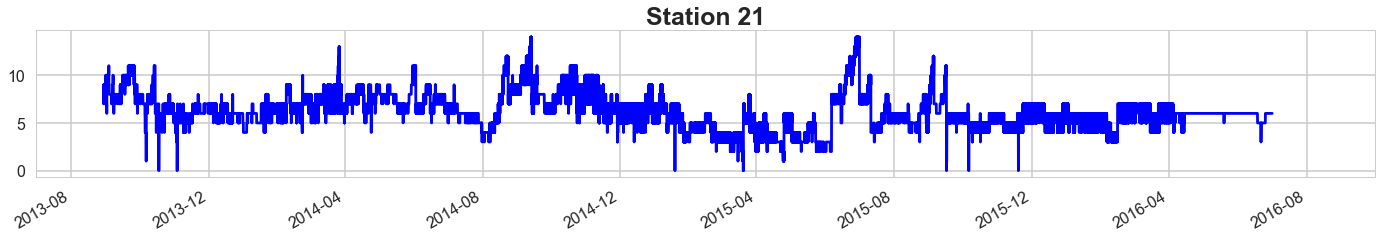

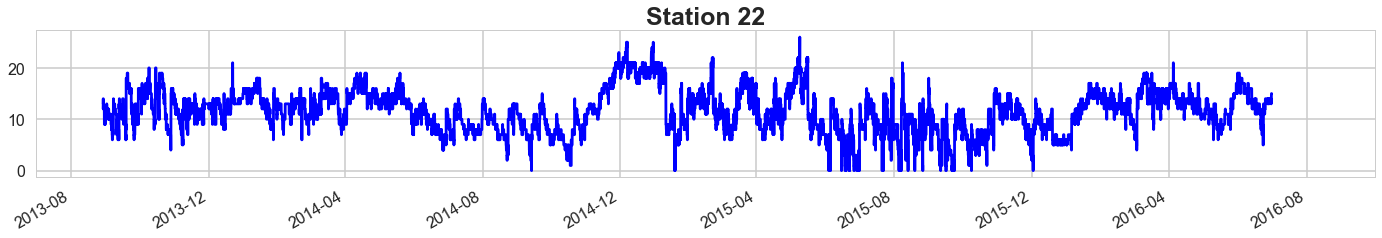

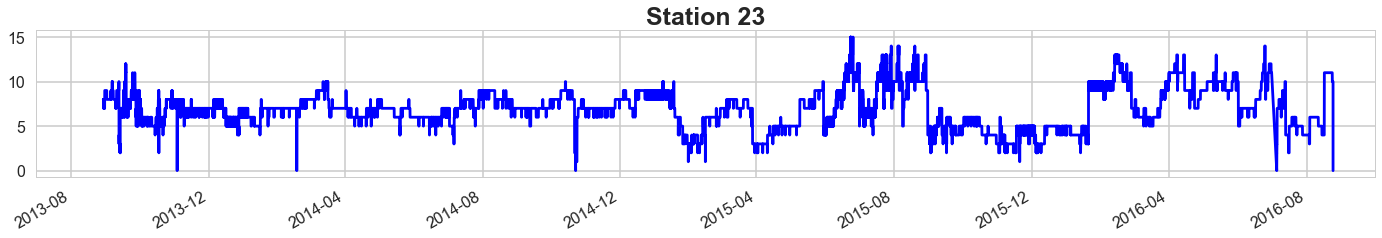

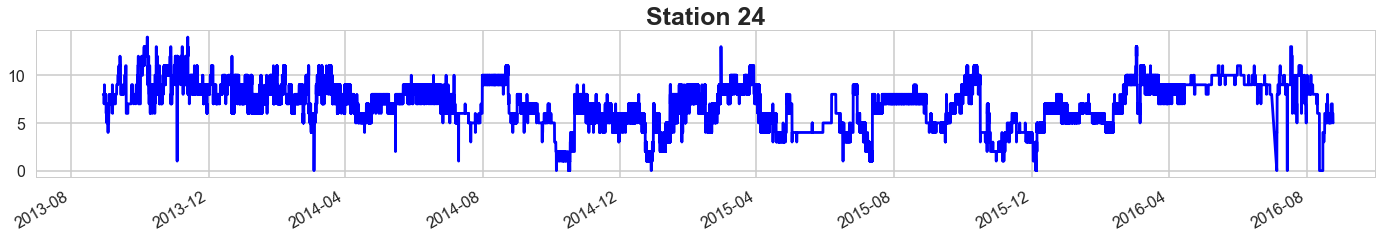

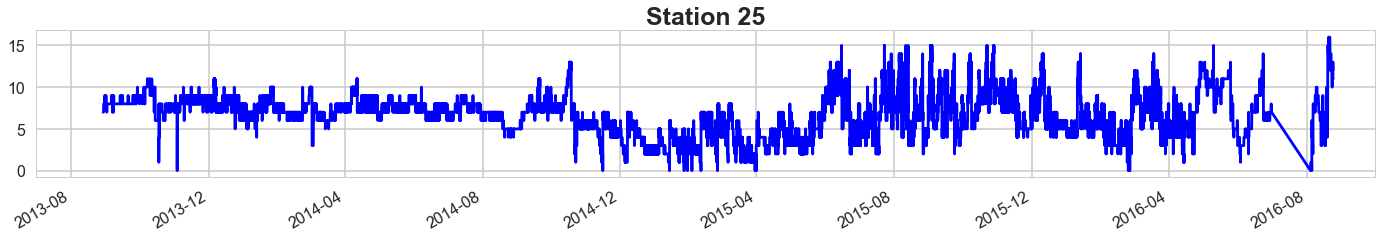

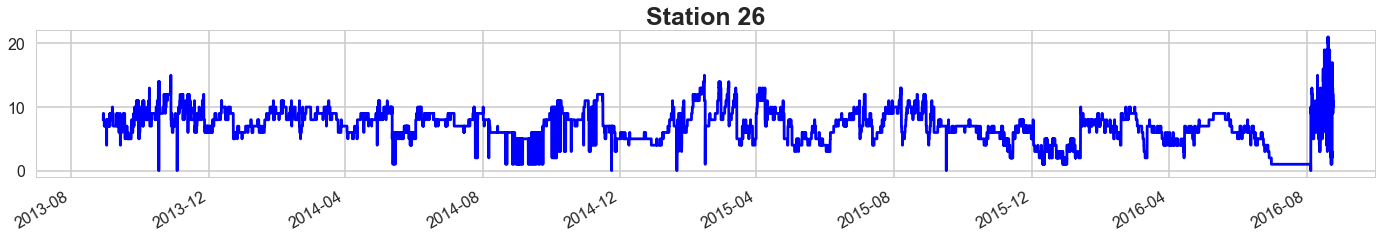

In [12]:
closed_stations = [21, 22, 23, 24, 25, 26]

t_min = pd.Timestamp('2013-07-01')
t_max = pd.Timestamp('2016-10-01')

for station in closed_stations:
    show_station(status_df, station, t_min, t_max)

## 'New' stations prior to cleaning

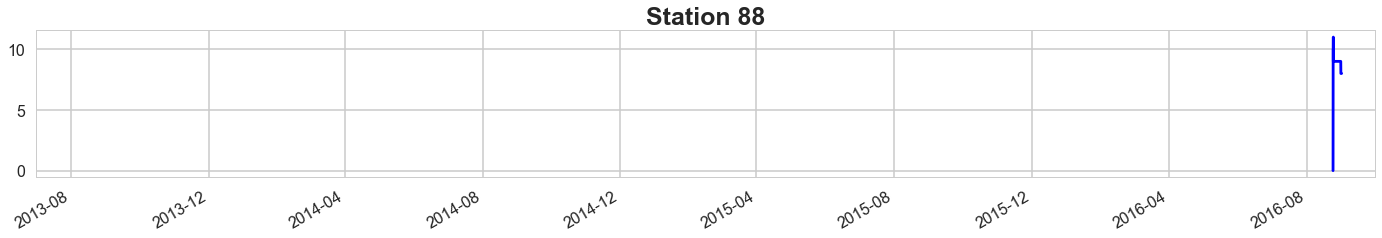

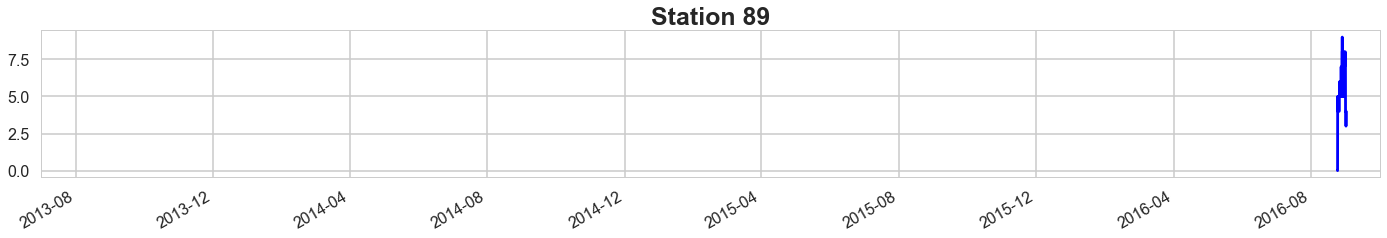

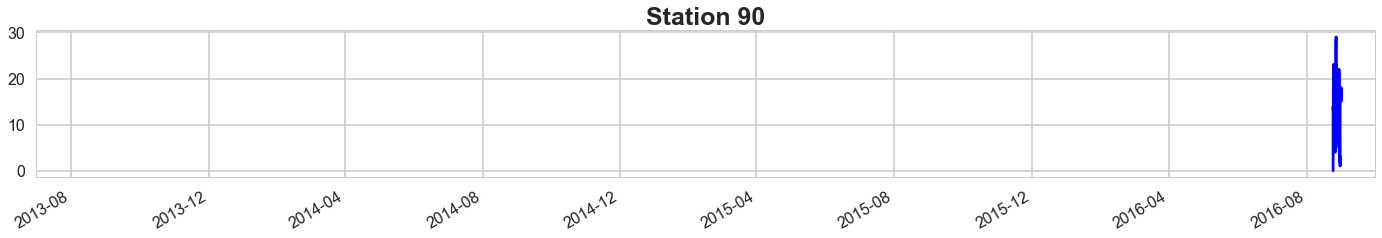

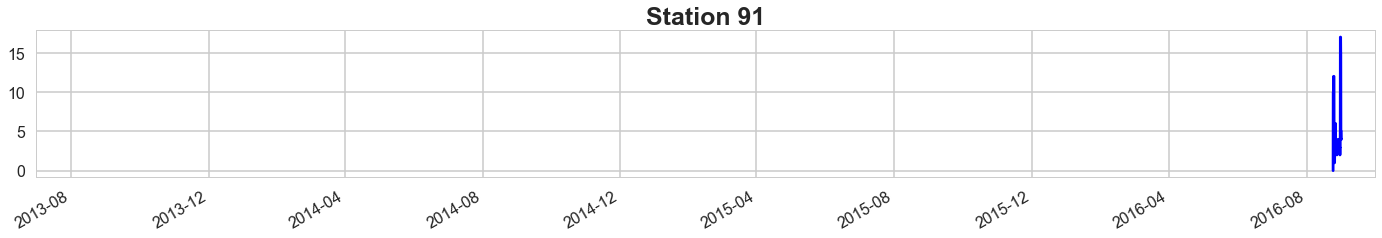

In [13]:
relocated_stations = [88, 89, 90, 91]

for station in relocated_stations:
    show_station(status_df, station, t_min, t_max)

## Correct Stations Dates for Status Records

[23:58:09.009752] Updating 23 to 88 for dates after 2016-07-05 00:00:00
[23:58:09.011226] Started indexing...
[23:58:15.204824] Complete!
[23:58:15.207882] Started Update...
[23:59:43.426831] Complete!


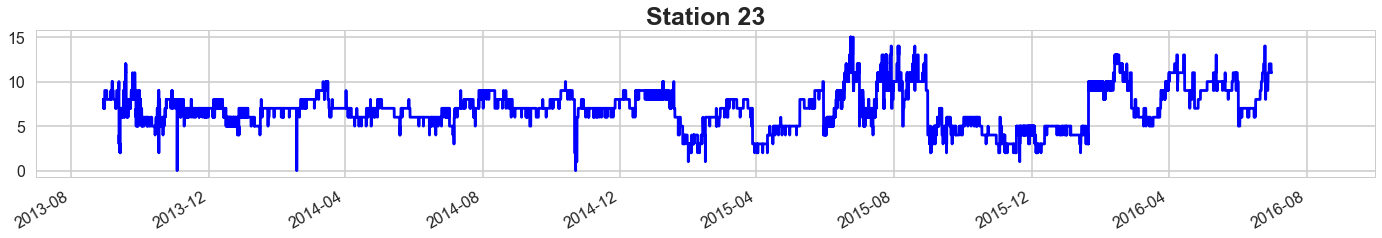

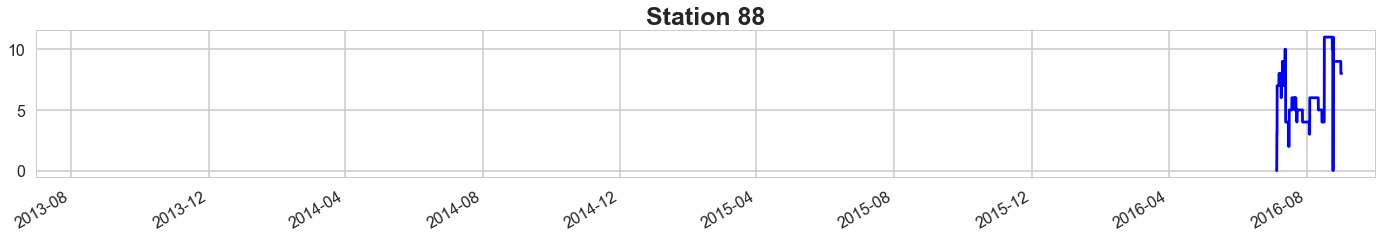

[23:59:47.765786] Updating 24 to 89 for dates after 2016-07-05 00:00:00
[23:59:47.766312] Started indexing...
[23:59:54.564670] Complete!
[23:59:54.565011] Started Update...
[00:00:08.680205] Complete!


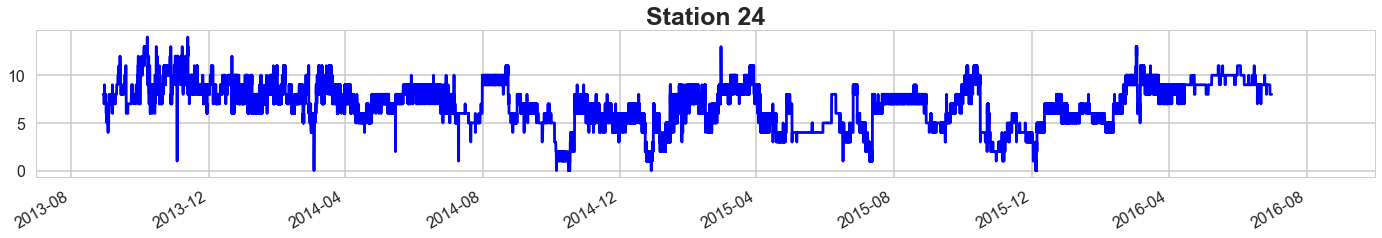

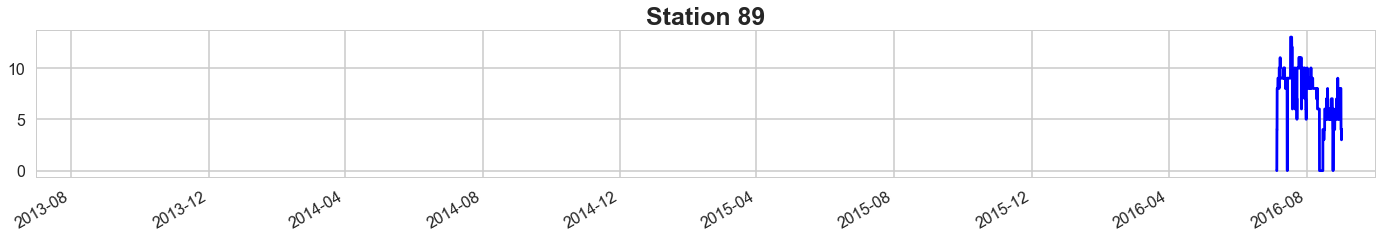

[00:00:13.003458] Updating 25 to 91 for dates after 2016-08-04 00:00:00
[00:00:13.003708] Started indexing...
[00:00:17.482226] Complete!
[00:00:17.482468] Started Update...
[00:00:30.382862] Complete!


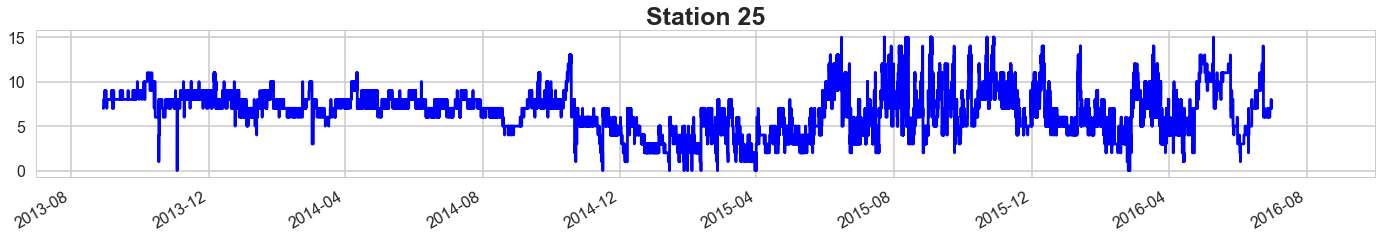

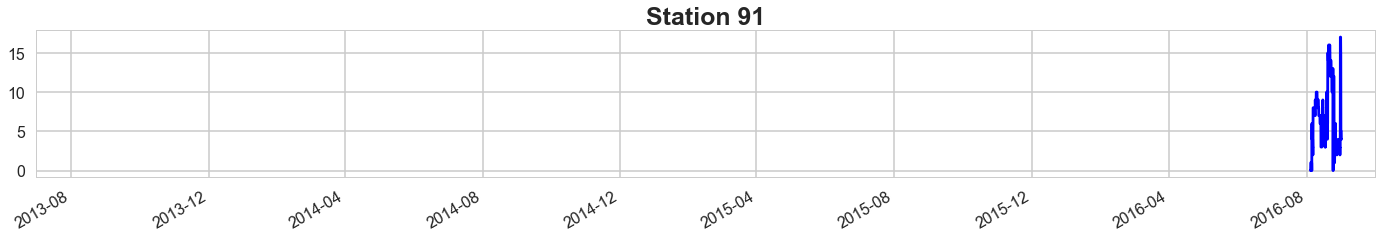

[00:00:35.303346] Updating 26 to 90 for dates after 2016-08-04 00:00:00
[00:00:35.303552] Started indexing...
[00:00:37.417153] Complete!
[00:00:37.417344] Started Update...
[00:00:46.616099] Complete!


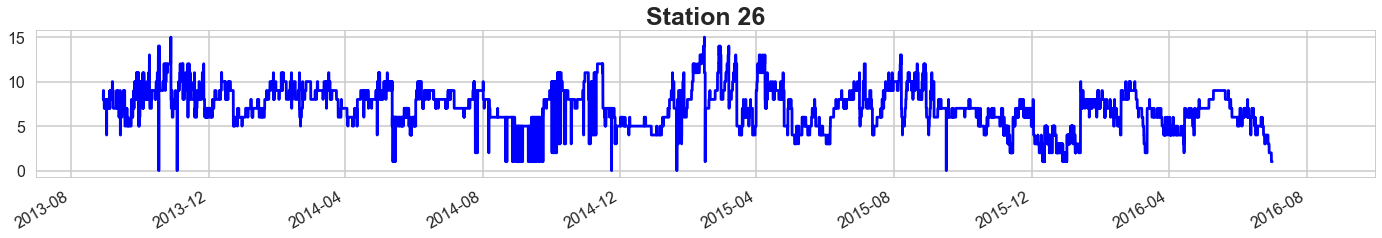

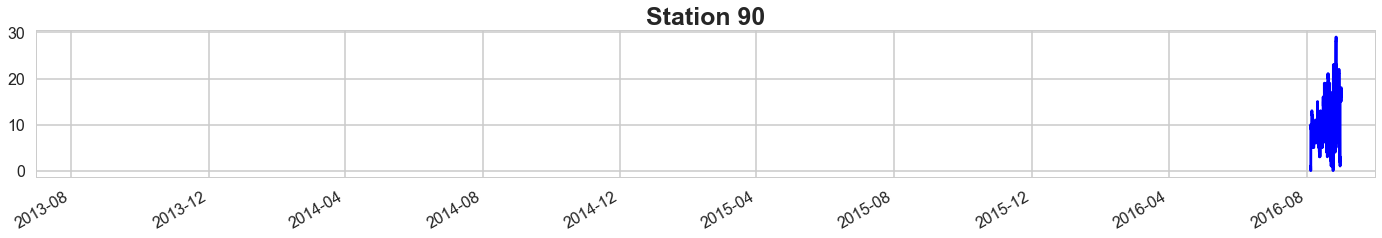

In [14]:
# stations 23 and 24 were relocated on July 5, 2016
change_date = datetime.datetime.strptime('2016-07-05', '%Y-%m-%d')
status_df = date_fixes(df=status_df, old_station=23, new_station=88, change_date=change_date)
status_df = date_fixes(df=status_df, old_station=24, new_station=89, change_date=change_date)

# stations 25 and 26 were relocated on August 4th, 2016
change_date = datetime.datetime.strptime('2016-08-04', '%Y-%m-%d')
status_df = date_fixes(df=status_df, old_station=25, new_station=91, change_date=change_date)
status_df = date_fixes(df=status_df, old_station=26, new_station=90, change_date=change_date)

In [15]:
status_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107233138 entries, 0 to 107233298
Data columns (total 4 columns):
station_id         int64
bikes_available    int64
docks_available    int64
time               datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 9.0 GB


In [16]:
status_df.head()

,station_id,bikes_available,docks_available,time
0,2,12,15,2014-03-01 00:00:00
1,2,12,15,2014-03-01 00:01:00
2,2,12,15,2014-03-01 00:02:00
3,2,12,15,2014-03-01 00:03:00
4,2,12,15,2014-03-01 00:04:00


# Load Station Data

In [17]:
# load Station Data
stations_df = pd.DataFrame()
stations_df = pd.read_csv('../../clean_data/bayareabikeshare/sf_station_data_cleaned.csv', index_col=0, parse_dates=['first_service_date', 'last_service_date'])

# drop non necessary columns
stations_df = stations_df[['station_id', 'dock_count']]
stations_df.drop_duplicates(subset=['station_id'], inplace=True)
stations_df.head(3)

,station_id,dock_count
0,39,19
1,41,15
2,42,15


# Append Dock Count

In [18]:
status_df = status_df.merge(stations_df, left_on=['station_id'], right_on=['station_id'], how='left')
status_df.head()

,station_id,bikes_available,docks_available,time,dock_count
0,2,12,15,2014-03-01 00:00:00,NaN
1,2,12,15,2014-03-01 00:01:00,NaN
2,2,12,15,2014-03-01 00:02:00,NaN
3,2,12,15,2014-03-01 00:03:00,NaN
4,2,12,15,2014-03-01 00:04:00,NaN


# Correct Dock Count on Expanded Station 73
<p>station 73 was expanded from 15 docks to 19 docks on May 19, 2016</p>

In [19]:
def correct_dock_count(df=None, change_date=change_date, new_dock_count=0):

    change_records = df[df.index > change_date].index

    dock_count_col_index = df.columns.tolist().index('dock_count')
    df.iloc[change_records,dock_count_col_index] = new_dock_count
    return df

## Remove all non San Francisco Stations

In [20]:
#subset to only include sf stations
status_df = status_df[status_df.station_id.isin(sf_station_ids)].copy()

status_df.reset_index(inplace=True, drop=True)

In [21]:
status_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54286239 entries, 0 to 54286238
Data columns (total 5 columns):
station_id         int64
bikes_available    int64
docks_available    int64
time               datetime64[ns]
dock_count         float64
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.0 GB


In [23]:
for s in status_df.station_id.unique():
    print('Station {:d} has {:d} records'.format(s, status_df[status_df.station_id == s].shape[0]))

Station 39 has 1555448 records
Station 41 has 1555594 records
Station 42 has 1555630 records
Station 45 has 1555598 records
Station 46 has 1555577 records
Station 47 has 1555584 records
Station 48 has 1555598 records
Station 49 has 1555622 records
Station 50 has 1555602 records
Station 51 has 1552790 records
Station 54 has 1555609 records
Station 55 has 1554684 records
Station 56 has 1555637 records
Station 57 has 1555627 records
Station 58 has 1553493 records
Station 59 has 1555569 records
Station 60 has 1555728 records
Station 61 has 1555775 records
Station 62 has 1553586 records
Station 63 has 1550458 records
Station 64 has 1555665 records
Station 65 has 1555741 records
Station 66 has 1555611 records
Station 67 has 1555677 records
Station 68 has 1555592 records
Station 69 has 1555859 records
Station 70 has 1555834 records
Station 71 has 1555577 records
Station 72 has 1555592 records
Station 73 has 1549190 records
Station 74 has 1555739 records
Station 75 has 1555615 records
Station 

In [24]:
tm('writing to file...')
status_df.to_csv('../../clean_data/bayareabikeshare/sf_status_data.csv', encoding='utf-8')
tm('done!')

[00:03:17.485900] writing to file...
[00:12:22.924720] done!


# Split by Station ID and Save to CSV

In [25]:
# for sid in sorted(status_df.station_id.unique()):
#     station_status = pd.DataFrame()
#     print('Station %d - station_status started' % sid)
#     station_status = status_df[status_df.station_id == sid].copy()
    
#     station_status.set_index('time', inplace=True, drop=True)
#     station_status_1min = station_status.resample('1Min').min()
#     station_status_1min.fillna(method='ffill', inplace=True)
    
#     station_status_5min = station_status.resample('5Min').min()
#     station_status_5min.fillna(method='ffill', inplace=True)
    
    
    
#     # correct station count    
#     if sid == 73:
        
#         # adjust 1min sample dock count
#         station_status_1min.reset_index(inplace=True)
#         change_date = datetime.datetime.strptime('2016-03-24', '%Y-%m-%d')
#         change_records = station_status_1min[station_status_1min.time >= change_date].index
        
#         dock_count_col_index = station_status_1min.columns.tolist().index('dock_count')
#         station_status_1min.iloc[change_records,dock_count_col_index] = 19
#         station_status_1min.set_index(['time'], inplace=True)

        
#         # adjust 5min sample dock count
#         station_status_5min.reset_index(inplace=True)
#         change_date = datetime.datetime.strptime('2016-03-24', '%Y-%m-%d')
#         change_records = station_status_5min[station_status_5min.time >= change_date].index
        
#         dock_count_col_index = station_status_5min.columns.tolist().index('dock_count')
#         station_status_5min.iloc[change_records,dock_count_col_index] = 19
#         station_status_5min.set_index(['time'], inplace=True)

#     # calculate utilization
#     station_status_1min['utilization'] = station_status_1min.docks_available / station_status_1min.dock_count
#     station_status_5min['utilization'] = station_status_5min.docks_available / station_status_5min.dock_count
        
#     if (station_status_1min.utilization.max() > 1.0) or (station_status_5min.utilization.max() > 1.0):
#         print('Staion %s has a utilization greater than 1.0, you should look into this' % sid)
#         # calculate utilization
#         station_status_1min.utilization.plot(figsize=(24,3), color='g', alpha=0.2)
#         station_status_5min.utilization.plot(figsize=(24,3), color='r', alpha=0.2)
#         plt.title('Dock Utilization')
#         plt.show()
#         plt.close()

#     # write file
#     station_status_1min.reset_index(inplace=True)
#     station_status_1min.to_csv('../../clean_data/bayareabikeshare/status_data/full/station_%s_status_data_cleaned.csv' % sid, encoding='utf-8')

#     station_status_5min.reset_index(inplace=True)
#     station_status_5min.to_csv('../../clean_data/bayareabikeshare/status_data/5min_resample_mean/station_%s_resampled_status_data_cleaned.csv' % sid, encoding='utf-8')
    
#     print('Station %d complete!' % sid)

In [26]:
# status_df.head()